# **Predicting Auction Sale Price: Trees vs. Deeplearners vs. Ensembles**

**Problem Description**\
Kaggle Competition: Predicting the auction sale price of a piece of heavy equipment to create a 'blue book' for bulldozers

# Installing the necessary libraries

In [2]:
#hide
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
from fastbook import *
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 31.5 MB/s 
     |████████████████████████████████| 62 kB 1.0 MB/s 
     |████████████████████████████████| 1.2 MB 67.2 MB/s 
     |████████████████████████████████| 46 kB 3.6 MB/s 
     |████████████████████████████████| 189 kB 69.8 MB/s 
     |████████████████████████████████| 56 kB 5.7 MB/s 
     |████████████████████████████████| 51 kB 377 kB/s 
Mounted at /content/gdrive


# Installing Kaggle:
The data will be downloaded directly from kaggle using the kaggle api

In [ ]:
!pip install kaggle

## Credentials: 
a string containing a dictionary holding user information\
creds = "{'username':'mykaggleusername', 'key':'mykagglegeneratedkey'}" 

In [4]:
# Loading credentials already saved as json in google drive
import json
creds = open('/content/gdrive/MyDrive/credentials.json')
creds = json.load(creds)

In [5]:
#Setting kaggle credentials path
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [6]:
#hide
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

## **Gathering the Dataset**


Picking a path to download the dataset to:

In [7]:
path = URLs.path('bluebook')
Path.BASE_PATH = path

Using the Kaggle API to download the dataset to the set path and extracting it

In [ ]:
if not path.exists():
    path.mkdir(parents=true)
    api.competition_download_cli('bluebook-for-bulldozers', path=path)
    #file_extract(path/'bluebook-for-bulldozers.zip')
!unzip /root/.fastai/archive/bluebook/bluebook-for-bulldozers.zip -d /root/.fastai/archive/bluebook
path.ls(file_type='text')

## **Loading in pandas dataframe**


In [9]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

In [10]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,...,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,...,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,...,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,...,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,...,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,...,NaN,NaN,NaN,NaN


## **Exploring the features present**

L() is a method in fastai's L object.

In [11]:
L([i for i in df.columns])

(#53) ['SalesID','SalePrice','MachineID','ModelID','datasource','auctioneerID','YearMade','MachineHoursCurrentMeter','UsageBand','saledate'...]

There are 53 features present as indicated by the fastai L object

### **Ordinal features**


Ordinal features are made of strings or similar but have a natural ordering. For example the product size i.e. ProductSize. Let's view the levels of product sizes below:


In [12]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

The sizes are not in order. We can fix this by specifying the categories in an ordered manner using a tuple like so:


In [13]:
sizes = 'Large','Large/Medium','Medium','Small','Mini','Compact'

In [14]:
#changing the type to category 
df['ProductSize']=df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

In [15]:
df['ProductSize'].unique()

[NaN, 'Medium', 'Small', 'Mini', 'Large', 'Compact']
Categories (5, object): ['Large' < 'Medium' < 'Small' < 'Mini' < 'Compact']

### **Specifying the dependent variable**

The dependent variable -- the item to be predicted -- is the sales price. Actually, the log of the sales price as specified by the competition organizers.

In [16]:
dep_var = 'SalePrice'
df[dep_var][:10]

0    66000.0
1    57000.0
2    10000.0
3    38500.0
4    11000.0
5    26500.0
6    21000.0
7    27000.0
8    21500.0
9    65000.0
Name: SalePrice, dtype: float64

Taking the log of the sale prices

Kaggle already specified what metric to use: root mean squared log error (RMSLE) between the actual and predicted auction prices. We need do only a small amount of processing to use this: we take the log of the prices, so that rmse of that value will give us what we ultimately need:

In [17]:
df[dep_var]=np.log(df[dep_var])
df[dep_var][:10]

0    11.097410
1    10.950807
2     9.210340
3    10.558414
4     9.305651
5    10.184900
6     9.952278
7    10.203592
8     9.975808
9    11.082143
Name: SalePrice, dtype: float64

# Decision tree algorithm

Decision tree ensembles, as the name suggests, rely on decision trees. A decision tree asks a series of binary (that is, yes or no) questions about the data. After each question the data at that part of the tree is split between a "yes" and a "no" branch, as shown in the image below. After one or more questions, either a prediction can be made on the basis of all previous answers or another question is required. (source: https://github.com/fastai/fastbook/blob/master/09_tabular.ipynb). 
Decision trees as a supervised learning technique is used for both classification and regression problems, but often applied for classification.
Internal nodes represent the features of the dataset, branches represent the desicion rules, and leaf nodes represent the outcome.


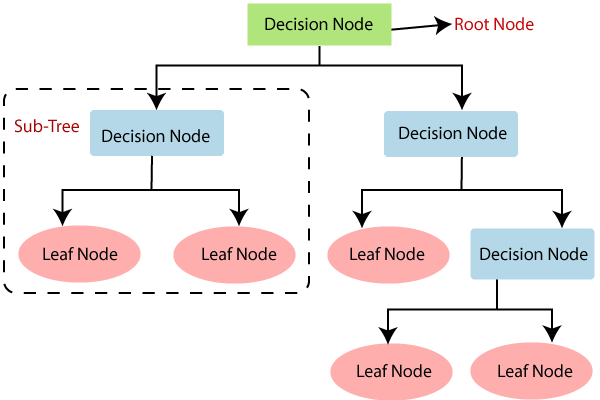

Image source: https://www.javatpoint.com/machine-learning-decision-tree-classification-algorithm 

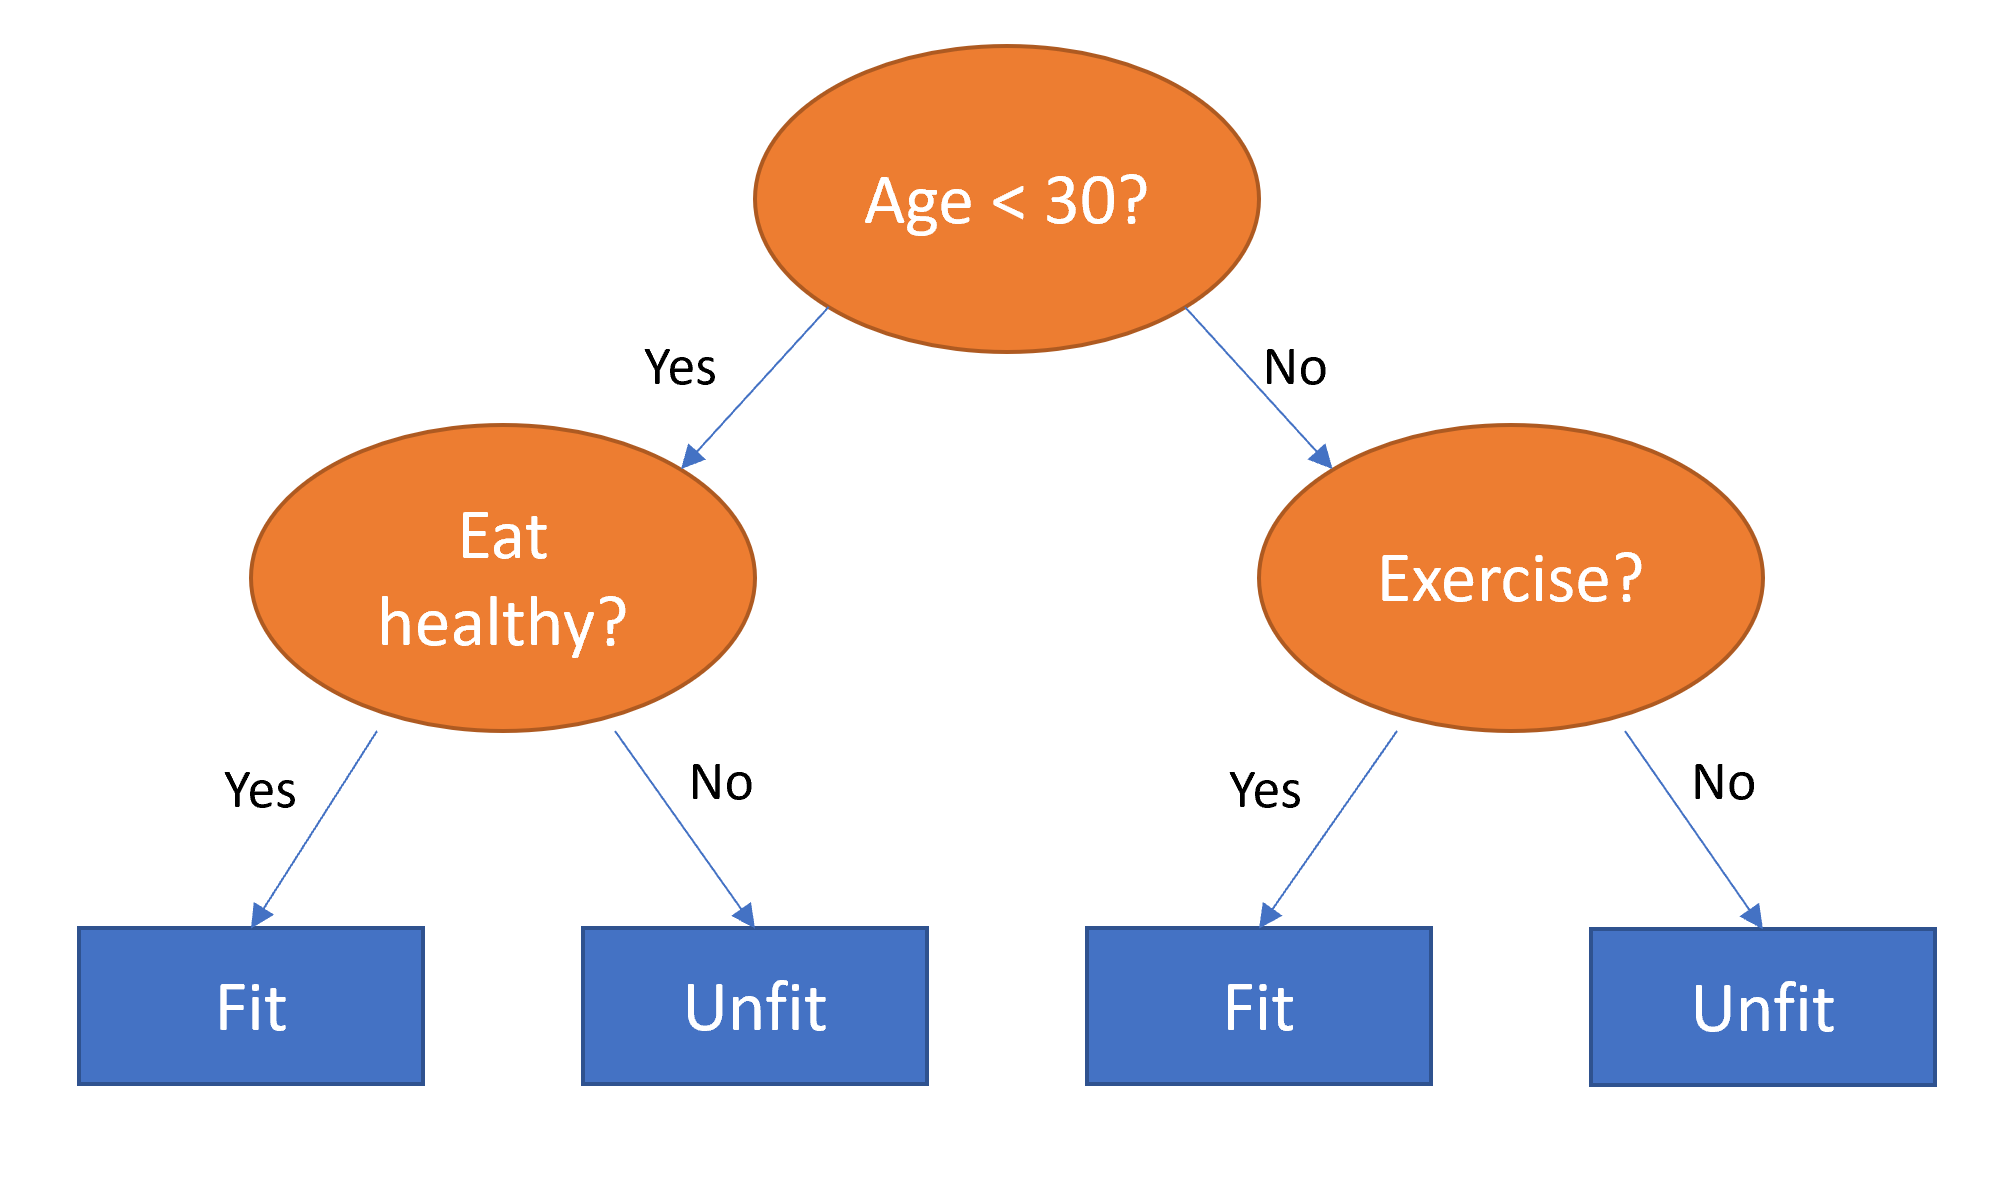

The basic steps to train a decision tree are easily:

1.   Loop through each column of the dataset in turn
2.   For each column, loop through each possible level of that column in turn
3.   Find the average sale price for each of those two groups, and see how close that is to the actual sale price of each of the items of equipment in that group. That is, treat this as a very simple "model" where our predictions are simply the average sale price of the item's group.
4.  After looping through all of the columns and all the possible levels for each, pick the split point that gave the best predictions using that simple model.
5.  We now have two different groups for our data, based on this selected split. Treat each of these as separate datasets, and find the best split for each by going back to step 1 for each group.
6.  Continue this process recursively, until you have reached some stopping criterion for each group—for instance, stop splitting a group further when it has only 20 items in it.
 








### **Data Preparation**

**Handling Dates**

The first bit of data preparation I did was to enrich the dates.

You might want to treat a date as an ordinal value, because it is meaningful to say that one date is greater than another. However, dates are a bit different from most ordinal values in that some dates are qualitatively different from others in a way that that is often relevant to the systems being modeled.

In order to help our algorithm handle dates intelligently, we'd like our model to know more than whether a date is more recent or less recent than another. We might want our model to make decisions based on that date's day of the week, on whether a day is a holiday, on what month it is in, and so forth. To do this, we replace every date column with a set of date metadata columns, such as holiday, day of week, and month. These columns provide categorical data that we suspect will be useful.

The `add_datepart` function in fastai can do the separation into month, year and day

In [18]:
old_length = len(df.columns)
df = add_datepart(df, 'saledate')
new_length = len(df.columns)
print(f'the training set has been enriched with {(new_length - old_length)+1} features')

the training set has been enriched with 13 features


In [19]:
df[['saleMonth','saleYear','saleDay']].head()

,saleMonth,saleYear,saleDay
0,11,2006,16
1,3,2004,26
2,2,2004,26
3,5,2011,19
4,7,2009,23


 Enriching the test set using the date feature

In [20]:
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
oldTest_length = len(df_test.columns)
df_test = add_datepart(df_test, 'saledate')
newTest_length = len(df_test.columns)
print(f'the test set has been enriched with {(newTest_length - oldTest_length)+1} features')

the test set has been enriched with 13 features


In [21]:
L([o for o in df.columns if o.startswith('sale')])

(#13) ['saleYear','saleMonth','saleWeek','saleDay','saleDayofweek','saleDayofyear','saleIs_month_end','saleIs_month_start','saleIs_quarter_end','saleIs_quarter_start'...]

This is a good first step, but we will need to do a bit more cleaning. For this, we will use fastai objects called `TabularPandas` and `TabularProc`.

### **Using TabularPandas and TabularProc**
sklearn cannot handle strings and missing data out of the box. As a result, we will use fastai's `Categorify` and `FillMissing` to encode the categorical variables and impute missing data, respectively. Both are `TabularProc`s

In [22]:
procs = [Categorify, FillMissing]

### Splitting the data using TabularPandas
Because this is a time series, we need to be careful with how we split the\ data. We want to define our validation data so that it has the same sort of relationship to the training data as the test set will have, at the same time,we want to ensure that our model is able to predict the future. Therefore, if we are going to have a useful validation set, we also want the validation set to be later in time than the training set.

The data ends in April 2012, thus, we will define a training data that consists of data from before November 2011 and test data will consist of data from November to April 2012.

In [23]:
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [24]:
type(splits), len(splits), len(splits[0]), len(splits[1])

(tuple, 2, 404710, 7988)

In [25]:
print(f'We have collected {len(splits[0])} indices for the training set and {len(splits[1])} indices for the test set')

We have collected 404710 indices for the training set and 7988 indices for the test set


In [26]:
#specifying the continuous and categorical features
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [27]:
#Passing the training data, proc list, feature types, dependent variables, and split indices as arguments to Tabularpandas
tab_obj = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [28]:
#checking the first five rows
tab_obj.show(5)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340
3,High,PC120-6E,PC120,#na#,-6E,#na#,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metric Tons",Texas,TEX,Track Excavators,#na#,EROPS w AC,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139251,1026470,332,121,3.0,2001,3486.0,2011,5,20,19,3,139,1.305763e+09,10.558414
4,Medium,S175,S175,#na#,#na#,#na#,#na#,Skid Steer Loader - 1601.0 to 1751.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,EROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139253,1057373,17311,121,3.0,2007,722.0,2009,7,30,23,3,204,1.248307e+09,9.305651


The categorical variables still appear as strings, however, the underlying items are numeric.

In [29]:
tab_obj.items[cat]

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,...,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na
0,2,963,298,43,...,1,1,1,1
1,2,1745,529,57,...,1,1,1,1
2,1,336,111,0,...,1,1,1,1
3,1,3716,1381,0,...,1,1,1,1
4,3,4261,1538,0,...,1,1,1,1
...,...,...,...,...,...,...,...,...,...
401120,0,666,209,108,...,1,1,1,2
401121,0,666,209,108,...,1,1,1,2
401122,0,666,209,108,...,1,1,1,2
401123,0,490,160,108,...,1,1,1,2


The numbers associated with the levels of the categorical variables are chosen consecutively as they are seen in a column, so there's cary no particular meaning.So, all the numbers representing the levels have no meaning except in ProductSize because ProductSize was first concverted to a pandas standard category (which is ordered). We can view the classes asociated with each categorical feature using the classes attribute like so:

In [30]:
for feature in ["ProductSize", "UsageBand"]:
  print(f"{feature} classes: {tab_obj.classes[feature]}")

ProductSize classes: ['#na#', 'Large', 'Large/Medium', 'Medium', 'Small', 'Mini', 'Compact']
UsageBand classes: ['#na#', 'High', 'Low', 'Medium']


In [31]:
#Saving the Tabular pandas object so it can be reused later just by loading it
save_pickle('/content/gdrive/MyDrive/tab_obj.pkl',tab_obj)

#to load it later, simply use tab_obj = load_pickle(/content/gdrive/MyDrive/tab_obj.pkl')

# Creating the Decision Tree

In [32]:
#defining our dependent and independent variable
xs,y = tab_obj.train.xs, tab_obj.train.y
valid_xs,valid_y = tab_obj.valid.xs,tab_obj.valid.y

In [33]:
#creating the decision tree model
tree_model = DecisionTreeRegressor(max_leaf_nodes=4)
tree_model.fit(xs, y);

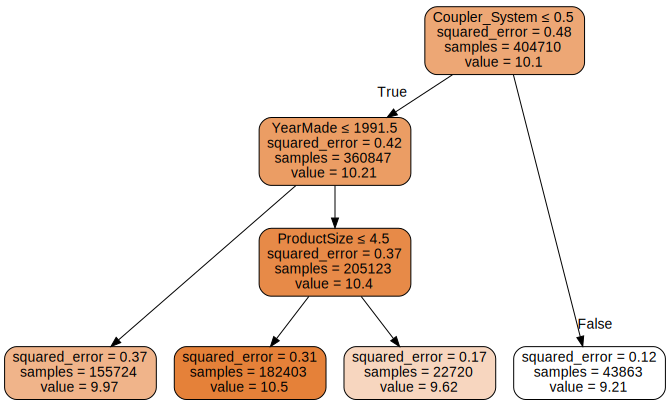

In [34]:
#displaying what has been learned:
draw_tree(tree_model, xs, size=10, leaves_parallel=True, precision=2)

### **A more detailed visualization using the Terence Parr's dtreeviz library**

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  "X does not have valid feature names, but"


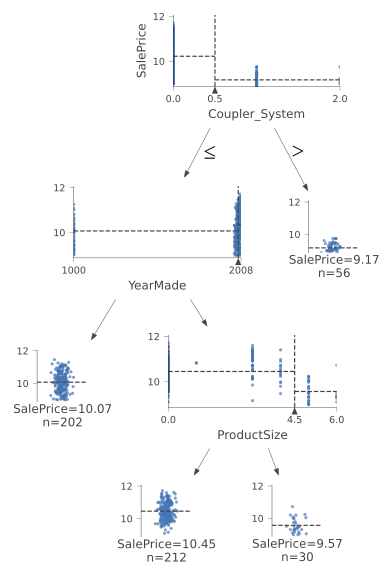

In [35]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(tree_model, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='TB')

From the visualization, there is clearly something wrong with the YearMade node. 1000 as a year is obviously a missing value code (imputed as a placeholder for missing value), this makes it difficult to visualize the values we are interested in. let's replace it. In fact, let's replace all the years less than 1900 with 1950.

In [36]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  "X does not have valid feature names, but"


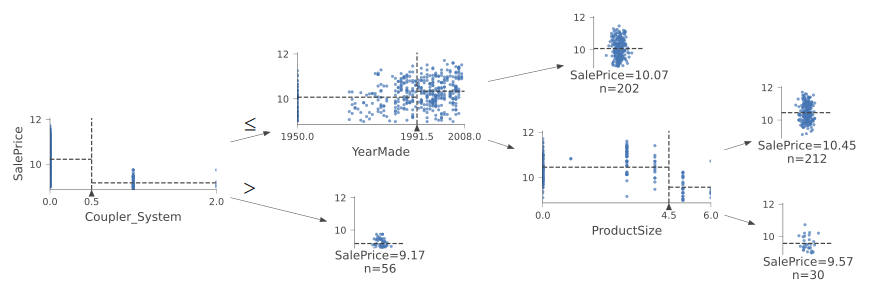

In [37]:
#Let's train our model and visualize again
tree_model = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)
dtreeviz(tree_model, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

###**Root mean squared error** 
Let's find out how our model is doing using the rmse measure

In [38]:
def r_mse(pred, y): 
  return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(model, xs, y): 
  return r_mse(model.predict(xs), y)

m_rmse(tree_model, xs, y)

0.55325

this is a large rmse, hence, our model will predict the sales price wrong 44% of the time. Perhaps, we set the stopping criteria `max_leaf_nodes` too low. 

In [39]:
for nodes in [4,16,64,256,1000,10000, None]:
  tree_model = DecisionTreeRegressor(max_leaf_nodes = nodes).fit(xs, y)
  print(f'max_leaf_nodes:{nodes}, m_rmse:{m_rmse(tree_model, xs, y)}')



max_leaf_nodes:4, m_rmse:0.55325
max_leaf_nodes:16, m_rmse:0.43539
max_leaf_nodes:64, m_rmse:0.36863
max_leaf_nodes:256, m_rmse:0.313003
max_leaf_nodes:1000, m_rmse:0.264227
max_leaf_nodes:10000, m_rmse:0.191736
max_leaf_nodes:None, m_rmse:0.0


Obviously, the `max_leaf_nodes` has an effect on the model's performance. The m_rmse improves as the `max_leaf_nodes` increases. However, it is possible that the model overfits when the `max_leaf_nodes` is set too high. So far we've only measured its performance against the training set, we can't be sure if it's overfitting until we've checked it against the validation set.

In [40]:
print('performance on the validation set\n')
for nodes in [4,16,64,256,1000,10000, None]:
  tree_model = DecisionTreeRegressor(max_leaf_nodes = nodes).fit(xs, y)
  print(f'max_leaf_nodes:{nodes}, m_rmse:{m_rmse(tree_model, valid_xs, valid_y)}')

performance on the validation set

max_leaf_nodes:4, m_rmse:0.55646
max_leaf_nodes:16, m_rmse:0.43406
max_leaf_nodes:64, m_rmse:0.373664
max_leaf_nodes:256, m_rmse:0.329251
max_leaf_nodes:1000, m_rmse:0.282106
max_leaf_nodes:10000, m_rmse:0.278952
max_leaf_nodes:None, m_rmse:0.337948


Now it is clear that the model overfitted when the stopping criterion was None

In [41]:
tree_model.get_n_leaves(), len(xs)

(324908, 404710)

Wow! We have almost as many leaves as the data points. The default stopping criteria specifies that the split be continued until there is only one item in each node. Let's see how the performance is affected by setting a minimum for the samples in the node to qualify for a split.

In [42]:
print('performance on the validation set min_leaf_nodes=25\n')
for nodes in [4,16,64,256,1000,10000, None]:
  tree_model = DecisionTreeRegressor(min_samples_leaf=25 ,max_leaf_nodes = nodes).fit(xs, y)
  print(f'max_leaf_nodes:{nodes}, m_rmse:{m_rmse(tree_model, valid_xs, valid_y)}')

performance on the validation set min_leaf_nodes=25

max_leaf_nodes:4, m_rmse:0.55646
max_leaf_nodes:16, m_rmse:0.43406
max_leaf_nodes:64, m_rmse:0.373664
max_leaf_nodes:256, m_rmse:0.329268
max_leaf_nodes:1000, m_rmse:0.282662
max_leaf_nodes:10000, m_rmse:0.270399
max_leaf_nodes:None, m_rmse:0.271151


**0.266813** looks so much better! let's check the number of leaves.

In [43]:
tree_model.get_n_leaves()

12390

Much more reasonable! We have gotten a better accuracy with less complexity

Might we get a better performance if we create different decision trees and average their predictions? It turns there is a named
approach to doing that exactly :Random Forests.

# **Random Forests**

This extremely powerful approach relies on a simple idea: pertubing the learning set to cause significant changes in the predictor constructed, thus, improving accuracy. Random forests involves taking the average of the predictions of a large number of decision trees, which are generated by randomly varying various parameters that specify what data is used to train the tree and other tree parameters.

Let's define a few of the parameters we are going to use:\
`n_estimators`: the number of trees\
`max_samples` : the number of rows to sample for each training tree\
`max_features`: the number of columns to sample at each split point\
`min_samples_leaf` : te number of samples in a leaf at which to stop splitting.\
`n_jobs = 1`: instructs sklearn to use all available CPUs to build the trees in parallel

In [44]:
def rf(x, y, n_estimators=100, max_samples=200_000, max_features=0.5, min_samples_leaf=5, **kwargs):
  return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, max_samples=max_samples, max_features=max_features,\
                               min_samples_leaf=min_samples_leaf, oob_score=True).fit(x, y)

In [45]:
rf_model = rf(xs, y)

### **Model's metrics**

In [46]:
def metrics(model, x_train, y_train, x_valid, y_valid):
  print(f'The RMSE on training set is {m_rmse(model, x_train, y_train)}')
  print(f'The RMSE on validation set is {m_rmse(model, x_valid, y_valid)}')

In [47]:
metrics(rf_model, xs, y, valid_xs, valid_y)

The RMSE on training set is 0.170114
The RMSE on validation set is 0.232374


In [48]:
save_pickle('/content/gdrive/MyDrive/rf100_model.pkl',rf_model)

Let's view the impact of the number of trees. We can start by getting the predictions from each individual tree like so:

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in rf_model.estimators_])
preds_train=np.stack([t.predict(xs) for t in rf_model.estimators_])

In [50]:
preds_train.shape

(100, 404710)

Each row of the array represents the predictions by an estimator. There are a total of 100 estimators or decision trees.

Recall that random forest takes the mean of all the predictions across the trees for each input. Let's compute this mean and check the performance. This should give the same result as our random forest.

In [51]:
r_mse(preds.mean(0), valid_y)

0.232374

## **RMSE vs. Trees**
How is the RMSE affected by the addition of more trees?

In [52]:
preds_val = pd.DataFrame(preds.copy(), index=["estimator_"+str(i) for i in range(preds.shape[0])])
pred_train = pd.DataFrame(preds_train.copy(), index=["estimator_"+str(i) for i in range(preds_train.shape[0])])
pred_train.head()

,0,1,2,3,...,404706,404707,404708,404709
estimator_0,11.138446,10.923877,9.295972,9.933118,...,9.307695,9.307695,9.260221,9.443987
estimator_1,10.988709,10.958920,9.387430,10.343802,...,9.362598,9.095332,9.396395,9.420734
estimator_2,10.728885,10.924876,9.148040,10.407634,...,9.276243,9.330526,9.566928,9.552129
estimator_3,11.087296,11.065496,9.354623,10.503326,...,9.302250,9.302250,9.644965,9.517207
estimator_4,10.996617,11.079645,9.669613,10.453381,...,9.572073,9.492819,9.384569,9.424311


In [53]:
rmses_val =[]
rmses_train = []
for i in range(preds_val.shape[0]):
  rmses_val.append(r_mse(preds_val[:i+1].mean(0).values, valid_y))
  rmses_train.append(r_mse(pred_train[:i+1].mean(0).values, y))
len(rmses_val)



100

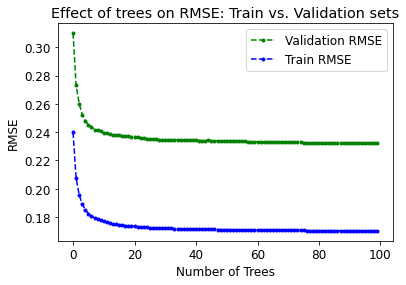

In [54]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(rmses_val))), rmses_val, linestyle="--", color="g", label="Validation RMSE", marker=".")
ax.plot(list(range(len(rmses_train))), rmses_train, linestyle="--", color="b", label="Train RMSE", marker=".")
ax.set_title("Effect of trees on RMSE: Train vs. Validation sets")
ax.set_ylabel("RMSE")
ax.set_xlabel("Number of Trees")
ax.legend(loc="best")
fig.show()

As can be observed from the plots, the improvement in RMSE levels off quite a bit around 30 trees. The performance on the validation set is worse than the training set. The reason could be overfitting or the differences in time periods in each set. We need to diagnose further inorder to come up with an answer. Out-of-bag error can help us with this.

## **Out-of-Bag Error**

The OOB error is a way of measuring prediction error on the training set by only including in the calculation of a row's error trees where that row was not included in the training. It is safe to think of this approach as allowing every tree have its own validation set. This validation set consist of the rows that were used for the tree's training. Since the OOB predictions are calculated on trees using the training set, they can be compared to the traning labels.

In [55]:
oob_rmse = r_mse(rf_model.oob_prediction_, y)
rmse_val = rmses_val[-1]
print(f'oob_rmse is {oob_rmse} and it is {(rmse_val-oob_rmse)/rmse_val*100}% better than validataion RMSE')


oob_rmse is 0.209202 and it is 9.971855715355419% better than validataion RMSE


This difference indicates that something else is responsible for the error, besides generalization error. Perhaps, we need to explore the predictions further.

# **How confident is our estimate?**

Recall that to get an overall prediction, random forest averages the individual tree's predictions. However, the mean doesn't provide clue as to the confidence of the estimate. Standard deviation of predictions across the trees can provide insights into the relative confidence of predictions. Clearly, it would benefit our model if we are more careful of using the results for rows where trees give very different results (higher standard deviations), as opposed to cases where they are more consistent (lower SD). 

In [56]:
preds_val.head()

,0,1,2,3,...,7984,7985,7986,7987
estimator_0,9.968985,10.078568,9.396071,9.329758,...,9.351128,9.351128,9.307695,9.307695
estimator_1,10.229416,9.980802,9.500562,9.368789,...,9.322509,9.322509,9.254665,9.254665
estimator_2,9.995845,10.143327,9.350214,9.338914,...,9.276124,9.276124,9.330526,9.330526
estimator_3,10.136236,10.310058,9.185180,9.272316,...,9.260363,9.260363,9.302250,9.302250
estimator_4,9.937578,10.010497,9.378399,8.949476,...,9.304480,9.304480,9.242111,9.242111


let's compute the SD...

In [57]:
std_arr = preds_val.std(0)
np.where(std_arr == std_arr.min()), np.where(std_arr==std_arr.max())

((array([5364]),), (array([6722]),))

The result shows that the trees agree most on the 5364th auction and agree least on the 6722nd auction. Below are the standard deviations at these auctions:

In [58]:
std_arr.min(), std_arr.max()

(0.04968184896339738, 0.6814760703971549)

If I were using this information in a production setting, I would be inclined to look more carefully at the 6722nd auction and others of similarly high standard deviation.

## **Feature Importance**
So for we've focused on improving the model's performance by trying different algorithmns and tuning some parameters, but we've largely unexplored the HOW question. How does our model make its prediction? Let's explore the feature importance. The `feature_importances_` attribute enabled by sklearn can be utilized here.

In [59]:
def rf_feat_importance(model, df):
  return pd.DataFrame({'cols':df.columns, 'imp':model.feature_importances_}
                      ).sort_values('imp', ascending=False)

In [60]:
feature_imp = rf_feat_importance(rf_model, xs)
feature_imp[:10]

,cols,imp
57,YearMade,0.180961
30,Coupler_System,0.112045
6,ProductSize,0.103552
7,fiProductClassDesc,0.074672
54,ModelID,0.055741
31,Grouser_Tracks,0.052631
65,saleElapsed,0.050706
3,fiSecondaryDesc,0.043429
12,Enclosure,0.035147
1,fiModelDesc,0.034662


Let's plot the feature importances:

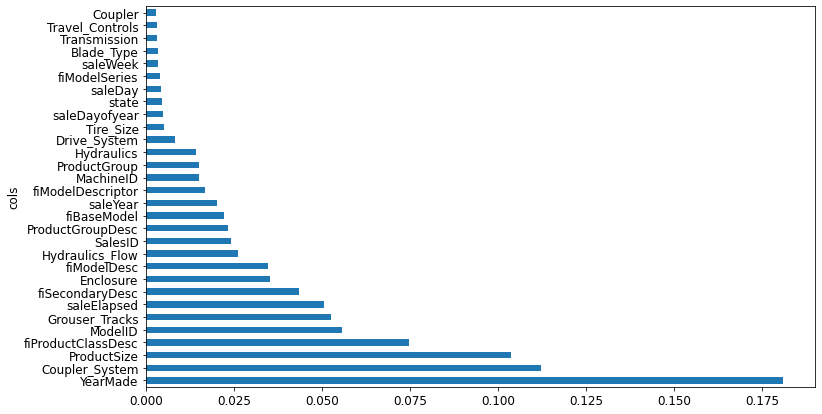

In [61]:
def plot_fi(feature_importance):
  return feature_importance.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(feature_imp[:30])

The feature importance plot above suggests that we might discard some of the columns and still get good results. The two most important features in our dataset appears to eb the `YearMade` and `Coupler System`. Let's remove the low importance variables.

In [62]:
retained_var = feature_imp[feature_imp.imp>0.005].cols
len(retained_var)

21

Let's retrain the model with the retained variables:

In [63]:
xs_imp = xs[retained_var]
valid_xs_imp = valid_xs[retained_var]

rfmodel_new = rf(xs_imp, y)
m_rmse(rfmodel_new, xs_imp, y), m_rmse(rfmodel_new, valid_xs_imp, valid_y)

(0.180787, 0.231264)

There is a lesson here: In general, the first step to improving a model is simplifying it. We should aim to work with few features as feasible. A simpler, more interpretable model is easier to roll out and maintain. 

Besides the feature importance, there is another approach to simplifying a model whuch involves removing redundant features. For instance, in our features set, the `ProductGroup` and `ProductGroupDesc` have very similar meanings. We can remove one of them

### **Removing Redundant Features**

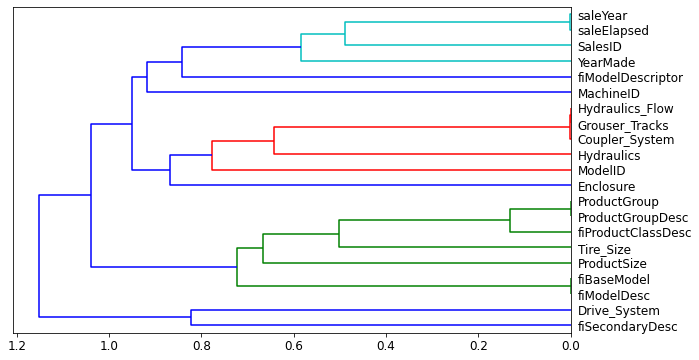

In [64]:
# let's start with:
cluster_columns(xs_imp)


The pairs of columns that are most similar are the ones that were merged together early i.e. far from the *root* of the tree at the left. `ProductGroup` and `ProductGroupDesc` were merged very early. Others include `saleYear` and `SaleElapsed`, then, `Hydraulics_Flow`, `Grouser_Tracks`, and `Coupler_System`, lastly, `fiBaseModel` and `fiModelDesc`. Let's remove the redundant features and retrain the model.

In [65]:
#the oob is called the R-squared value in statistics. A value of 1.0 represents a perfect model, 0.0 represents a random model
def get_oob(df):
  model = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
                                max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
  model.fit(df, y)
  return model.oob_score_

In [66]:
get_oob(xs_imp)

0.8754536788954463

Let's remove the redundant variables, one at a time:

In [67]:
{feature:get_oob(xs_imp.drop(feature, axis=1)) for feature in(
    'saleYear', 'saleElapsed', 'ProductGroupDesc', 'ProductGroup',
    'fiModelDesc', 'fiBaseModel', 'Hydraulics_Flow', 'Grouser_Tracks',
    'Coupler_System'
)}

{'Coupler_System': 0.8763230829668183,
 'Grouser_Tracks': 0.8767522893770925,
 'Hydraulics_Flow': 0.8761431477400757,
 'ProductGroup': 0.8759194512181298,
 'ProductGroupDesc': 0.8760998956550108,
 'fiBaseModel': 0.8755463817970557,
 'fiModelDesc': 0.8742066130463735,
 'saleElapsed': 0.8701286372699913,
 'saleYear': 0.8755359472298039}

Let's drop multiple items; one from each of the tighly aligned pairs.

In [68]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8721360175164453

In [69]:
xs_final = xs_imp.drop(to_drop, axis =1)
valid_xs_final=valid_xs_imp.drop(to_drop, axis =1)
rf_model=rf(xs_final, y)
m_rmse(rf_model, xs_final, y), m_rmse(rf_model, valid_xs_final, valid_y)

(0.182747, 0.232401)

In [70]:
save_pickle('/content/gdrive/MyDrive/xs_final.pkl', xs_final)
save_pickle('/content/gdrive/MyDrive/valid_xs_final.pkl', valid_xs_final)

### **Partial Dependence Plots**

Partial dependence plots try to answer the question: if a row varied on nothing other than the feature in question, how would it impact the dependent variable? E.g., how does `YearMade` impact sale price, all other things being equal?

We might think of taking the average sale price for each `YearMade`. This would be effective if the other features had not changed and possibly influenced the sale prices for the different years. Therefore, a more effective approach is to replace the `YearMade` across all samples with a single year, and compute the average over all the auctions. This is repeated for all the years.

For example, we can start by replacing all the years with 1950, then taking the average of the predictions. The same process is repeated for 1951, 1952, and so forth until the final year 2011. This isolate the effect of only the `Yearmade`. Let's make the partial dependence plot below:


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


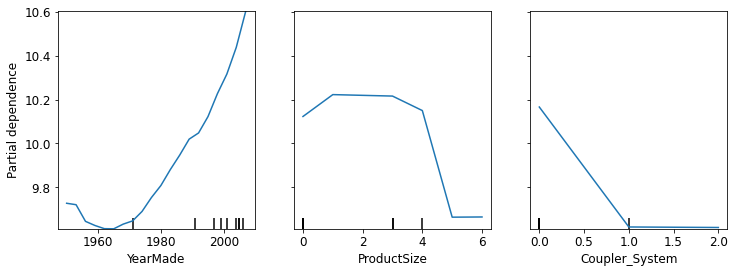

In [71]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(rf_model, valid_xs_final, ['YearMade', 'ProductSize', 'Coupler_System'],
                        grid_resolution=20, ax=ax);

The auction price seem to increase linearly with the year made (post 1970). However, we must realize that the trend is actually exponential because the auction price is the log value of the actual prices. Towards the end of the productsize plot, we see an interesting trend. The auction price is at its lowest in the end. This group represent the missing values in our product size. Missing values constitute the greatest percentage in our `ProductSize`. However, recall that productsize is our third most important feature. So, how is it possible that a feature that is missing so often be so important to the prediction? The answer may be tied to data leakage. We can theorize that the auctions with missing product size information were not really successful since they were sold at very low prices, as a resutlt, the size information were either removed or intentionally omitted. It is also possible that most of these data were collected after sales were made, and for the sales that were not great, the product size were simply left blank. The intention is completely debatable, one of such might be to provide clue as to the nature of the sale, however, such information can harm and model or even render it completely useless. Clearly, our model could be misled into thinking that missing product size is an indication of low price and as such will always predict a low price whenever the product size attribute is missing. A model afflicted with data leakage will not perform well in production.

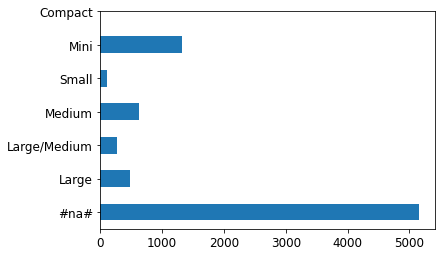

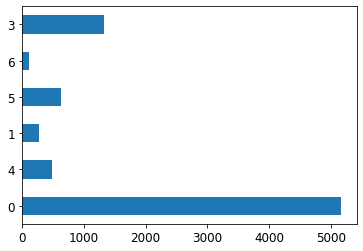

In [72]:
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = tab_obj.classes['ProductSize']
plt.yticks(range(len(c)), c)
plt.show()
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
plt.show()

What is the most occuring product size?

In [73]:
percents = valid_xs_final['ProductSize'].value_counts(normalize=True)*100
highest_per = max(valid_xs_final['ProductSize'].value_counts(normalize=True)*100)
modal_sz = np.where(percents == highest_per)
print(f'size {list(modal_sz[0])[0]} appears the most')

size 0 appears the most


### **Rationale for the predictions**

To explore this, we try to find out how the predictions ary as we vary the columns. One of the ways to do this is to use the 'treeinterpreter' and the 'waterfall_chart'.
We can study each row of our data by passing it through each of the decision trees in the random forest (`rf_model`). We observe what split is used at each node and note the corresponding increase or decrease, compared to the parent node. The process is repeated for all the trees and the total change in importance by split variable is calculated.

In the code below, we started by importing `treeinterpreter` and `plot` from `waterfall_chart`. Then, we grabbed the first five rows of the data, passed the data to our model, and finally grabbed the predictions, bias, and contributions in th first row. Lastly, we passed the contributions, along with the columns to the plot (aka waterfall) function and made the plot.

1. `prediction` is the prediction that is made by the random forest model
2. `bias` is the prediction based on taking the mean of the dependent variable
3. `contribution` reveals the change in prediction due to each of the indpendent variables.

`contributions` + `bias` = `prediction`

In [74]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

The prediction, bias, and contributions for the first item are (array([9.97999988]), 10.10466733865299, -0.12466746138965698) respectively


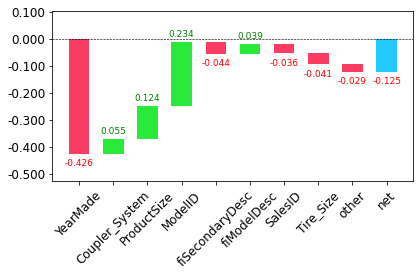

In [75]:
row = valid_xs_final.iloc[:5]
prediction, bias, contributions = treeinterpreter.predict(rf_model, row.values)
print(f'The prediction, bias, and contributions for the first item are {prediction[0], bias[0], contributions[0].sum()} respectively')
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, rotation_value=45, formatting='{:,.3f}');

## **Decision Trees and the Extrapolation Problem**

It is now common knowledge that decisio trees cannot be used for extrapolation. This is because it can only make a prediction by taking the average of previously observed data.Therefore, the predicions that a random forest can make is bound by the highest and lowest labels in the training data. This situation can become problematic when the training and prediction inputs differ in their range or distribution. This is called domain or covariate shift. Let's generate some fake data to illustrate this:

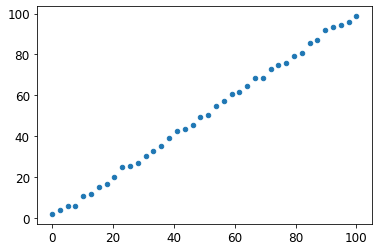

In [76]:
np.random.seed(42)
x_linear = torch.linspace(0, 100, steps = 40)
y_linear = x_linear + torch.randn_like(x_linear)
plt.scatter(x_linear, y_linear, 20);


Now, let's turn our training vector into a matrix (of one column) since sklearn only works well with matrices. Next, we set side 30% of the data as for testing and train the random forest regressor on 70% of the data, then, we plot our predictions:

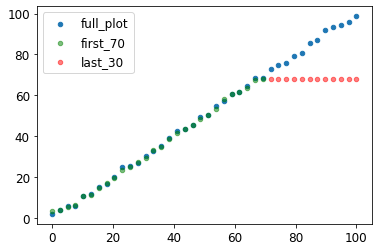

In [77]:
xs_linear = x_linear.unsqueeze(1)
first_70_train, first_70_label = (xs_linear[:int(len(xs_linear)*0.7)], y_linear[:int(len(y_linear)*0.7)])
last_30_test, last_30_label = xs_linear[int(len(xs_linear)*0.7):], y_linear[int(len(xs_linear)*0.7):]
linear_model = RandomForestRegressor().fit(first_70_train, first_70_label)

full_plot=plt.scatter(x_linear, y_linear, 20)
first_70=plt.scatter(first_70_train, linear_model.predict(first_70_train),20, color='green', alpha = 0.5)
last_30=plt.scatter(last_30_test, linear_model.predict(last_30_test),20, color='red', alpha=0.5)
plt.legend((full_plot, first_70, last_30), ('full_plot', 'first_70','last_30'));

As shown by the red line in the plot above, beyond the first 70% of the data, the model fails terribly. This is because the 30% data are out of domain of the training inputs.

so, now that we've illustrated a limitation of random forest,let's see how we can identify out of domain data:

In [78]:
df_domain = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

model = rf(df_domain, is_valid)
rf_feat_importance(model, df_domain)[:6]

,cols,imp
5,saleElapsed,0.892935
10,SalesID,0.080709
12,MachineID,0.020751
0,YearMade,0.001903
4,ModelID,0.000789
8,fiModelDesc,0.000510


In the above, we've created the domain data by concatenating the `xs_final` and `valid_xs_final`. Next, we created the labels: for the `xs_final` the labels were set to 0 and for the `valid_xs_final` 1 were assigned as the labels. We are trying to train a random forest that can tell if a given input is from a training set or validation set. This will help us to determine if a validation set has the same or similar distrubution as the training set.
Lastly, we computed the feature importances. The importance score reveals how crucial a particular feature was to the classification. Inotherwords, it reveals the degree of dissimilarity of the columns in the two sets. Here, `saleElapsed`, `SalesID`, and `MachineID` are the most significantly different features between the sets. Let's remove these columns one at  time to check the effect on the RMSE.

In [79]:
model = rf(xs_final, y)
print('orig', m_rmse(model, valid_xs_final, valid_y),'\n')

for c in ('SalesID','saleElapsed','MachineID'):
    model = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(model, valid_xs_final.drop(c,axis=1), valid_y))

orig 0.231121 

SalesID 0.229914
saleElapsed 0.234171
MachineID 0.230854


from the results, removing the `SalesID` and `MachineID` produced a greater positive effect on the accuracy. Let's take out both of them to see how that impacts the accuracy.

In [80]:
time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

model = rf(xs_final_time, y)
m_rmse(model, valid_xs_time, valid_y)

0.228821

Our accuracy has slightly improved. We now also have a less complex model that is easier to understand. Our last step would be to train our model on more recent data. Since, the auction sale price is a time dependent quantity, it is likely that a model trained on more recent data will perform better it terms of predicting future prices.

In [81]:
start_year = [1990, 2000, 2001, 2003]
for year in start_year:
  filt = xs['saleYear']>year
  xs_filt = xs_final_time[filt]
  y_filt = y[filt]

  model = rf(xs_filt, y_filt)
  print(f'Starting from {year}, training:{m_rmse(model, xs_filt, y_filt)}; validation:{m_rmse(model, valid_xs_time, valid_y)}')

Starting from 1990, training:0.190695; validation:0.229307
Starting from 2000, training:0.183105; validation:0.22917
Starting from 2001, training:0.181276; validation:0.22923
Starting from 2003, training:0.178895; validation:0.22945


Our model improves slightly if we choose to work with year 2000 upwards. Now let's compare our performance to neural networks.

## **Neural Networks**

We are going to replicate the processes we followed to create a tabular pandas object in the preceding steps.

In [82]:
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

Let's trim out the redundant columns but shouldn't forget to retain the dependent variable

In [83]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

### Handling categorical columns as embeddings:
The `max_card` parameter specifies the number of levels in a column below which a column is considered to be categorical 

In [84]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [85]:
print(f' continuous: {cat_nn}')
print(f' categorical: {cont_nn}')

 continuous: ['YearMade', 'Coupler_System', 'ProductSize', 'fiProductClassDesc', 'ModelID', 'fiSecondaryDesc', 'Enclosure', 'fiModelDesc', 'Hydraulics_Flow', 'fiModelDescriptor', 'ProductGroup', 'Hydraulics', 'Drive_System', 'Tire_Size']
 categorical: ['saleElapsed']


### cardinality of the categorical features:

In [86]:
df_nn_final[cat_nn].nunique()

YearMade                73
Coupler_System           2
ProductSize              5
fiProductClassDesc      74
ModelID               5281
fiSecondaryDesc        177
Enclosure                6
fiModelDesc           5059
Hydraulics_Flow          3
fiModelDescriptor      140
ProductGroup             6
Hydraulics              12
Drive_System             4
Tire_Size               17
dtype: int64

Two features `ModelID` and `fiModelDesc` stand out in their high cardinality values. Since both pertain to the model description, it is likely that they contain redundant information. If we can safely eliminate one of them then we can be sure to reduce our model's complexity to a great extent. 

In [87]:
xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)
model2 = rf(xs_filt2, y_filt)
m_rmse(model2, xs_filt2, y_filt), m_rmse(model2, valid_xs_time2, valid_y)

(0.178161, 0.229842)

Since there is minimal impact on the performance we will remove it as a predictor

In [88]:
cat_nn.remove('fiModelDescriptor')

### **Building the tabularpandas for nn:**
NN works better with normalized data, so we are going to include a normalization step:

In [89]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

### **Creating the dataloader, the dependent variable, and our first learner**

We created a learner with two hidden layers having 500 and 250 activations, respectively

In [90]:
dls = to_nn.dataloaders(1024)
y = to_nn.train.y

learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)


### choosing a learning rate

SuggestedLRs(valley=0.00010964782268274575)

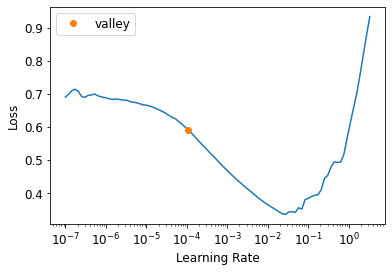

In [91]:
learn.lr_find()

In [92]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.063127,0.062756,00:04
1,0.054220,0.057031,00:04
2,0.047705,0.056232,00:04
3,0.043438,0.050834,00:04
4,0.040280,0.050358,00:04


In [93]:
#RMSE
preds,targs = learn.get_preds()
r_mse(preds,targs)


0.224405

The RMSE seems to have improved compared to our last result from the random forest

In [94]:
learn.save('nn')

Path('models/nn.pth')

### **Ensembling**

Let's make an ensemble of the random forest and neural network. We are going to take the average of the predictions by both models and check the RMSE of the resulting predictions.

In [95]:
rf_preds = model.predict(valid_xs_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2

In [96]:
r_mse(ens_preds,valid_y)

0.2219

Incredible! This is best result we've gotten so far. Apparently, an ensemble of models works better than a single model.

### **Histogram Based Gradient Boosting Regressor**

In [97]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
hbr=HistGradientBoostingRegressor(learning_rate=0.3, random_state=42).fit(xs_filt, y_filt)

/usr/local/lib/python3.7/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


In [98]:
hbr_prediction = hbr.predict(valid_xs_time)
hbr_rmse = r_mse(hbr_prediction, valid_y)
hbr_rmse

Let's take the average of the redctions by the three models and compute the RMSE

In [126]:
ensem = (to_np(preds.squeeze())+  rf_preds + hbr_prediction)/3
ermse = r_mse(ensem, valid_y)
ermse

### **Using the XGB Regressor**

In [106]:
#Importing the model and metrics
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#### **Defining the hyperparameter function and the grid search parameters**

In [107]:
def hyperParameterTuning(X_train, y_train):
  tuning_params = {
      'learning_rate': [0.01, 0.1],
      'max_depth': [3, 5, 7, 10],
      'min_child_weight': [1, 3, 5],
      'subsample': [0.5, 0.7],
      'colsample_bytree': [0.5, 0.7],
      'n_estimators': [100, 200, 500],
      'objective': ['reg:squarederror'],
       'tree_method':['gpu_hist'], 
       'predictor':['gpu_predictor']
  }
  xgb_model = XGBRegressor()
  grid_search = GridSearchCV(estimator=xgb_model,
                             param_grid = tuning_params,
                             cv=5,
                             n_jobs=-1,
                             verbose=1)
  grid_search.fit(X_train, y_train)
  return grid_search.best_params_


In [108]:
#hyperParameterTuning(xs_filt, y_filt)

In [109]:
best_prm = {'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 5,
 'n_estimators': 500,
 'objective': 'reg:squarederror',
 'predictor': 'gpu_predictor',
 'subsample': 0.7,
 'tree_method': 'gpu_hist'}

In [115]:
xgb_model = XGBRegressor(colsample_bytree= 0.5,learning_rate= 0.1,max_depth= 10,min_child_weight= 5,n_estimators= 500,\
                         objective= 'reg:squarederror',predictor= 'gpu_predictor',subsample= 0.7,\
                         tree_method= 'gpu_hist')

In [122]:
xgb_model = xgb_model.fit(xs_filt, y_filt, early_stopping_rounds=5, eval_set=[(valid_xs_time,valid_y)], verbose=False)


(7988,)

#### **Making predictions and computing the RMSE**

In [128]:
y_pred_xgb = xgb_model.predict(valid_xs_time)
r_mse(y_pred_xgb, valid_y)

0.225234

In [127]:
# Computing the average of NN predictions and xgboost prediction
xg_nn_preds = (to_np(preds.squeeze()) + y_pred_xgb) /2

#Computing the RMSE of the new predictions
r_mse(xg_nn_preds, valid_y)

0.220194

A combination of xgboost and neural network have produced the best performance!!